# Feasibility modeling



A more complicated example involves minimizing in two dimensions, where some parts of the parameter space are off-limits. Let's minimize Himmelblau's function, subject to the constraint that $x_1^2 + x_2^2 < 50$

Text(0, 0.5, 'x2')

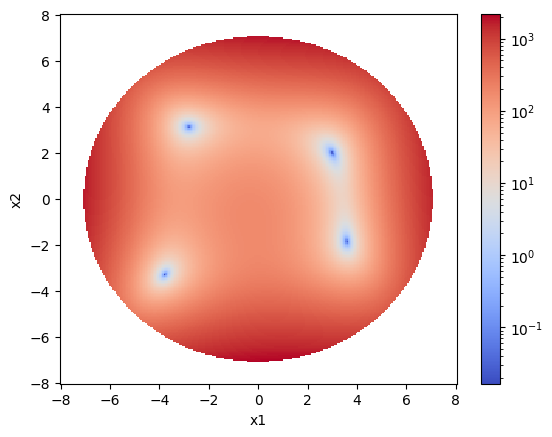

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from bloptools import test_functions

x1 = x2 = np.linspace(-8, 8, 256)
X1, X2 = np.meshgrid(x1, x2)
from bloptools.tasks import Task

task = Task(key="himmelblau", kind="min")
F = test_functions.constrained_himmelblau(X1, X2)

plt.pcolormesh(x1, x2, F, norm=mpl.colors.LogNorm(), shading="auto")
plt.colorbar()
plt.xlabel("x1")
plt.ylabel("x2")

where everything outside our constraint is undefined. In our digestion function, we return a `NaN` when we violate the constraint:

In [2]:
def digestion(db, uid):
    products = db[uid].table()

    for index, entry in products.iterrows():
        products.loc[index, "himmelblau"] = test_functions.constrained_himmelblau(entry.x1, entry.x2)

    return products

and create the agent in the usual way:



Transient Scan ID: 1     Time: 2023-08-11 05:54:12
Persistent Unique Scan ID: '28a13d88-cb29-4b2f-9d50-8bcfab116275'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 05:54:12.7 |      4.615 |     -6.168 |


|         2 | 05:54:12.7 |     -4.988 |      3.077 |
|         3 | 05:54:12.7 |     -3.109 |     -0.170 |
|         4 | 05:54:12.7 |      3.490 |      5.077 |
|         5 | 05:54:12.7 |      1.262 |     -3.447 |
|         6 | 05:54:12.7 |     -1.134 |      6.292 |
|         7 | 05:54:12.7 |     -6.761 |     -5.446 |
|         8 | 05:54:12.7 |      6.640 |      0.292 |
|         9 | 05:54:12.8 |      7.733 |     -1.903 |
|        10 | 05:54:12.8 |     -7.855 |      4.874 |
|        11 | 05:54:12.8 |     -0.227 |     -7.904 |
|        12 | 05:54:12.8 |      0.356 |      2.874 |
|        13 | 05:54:12.8 |      2.395 |     -4.744 |
|        14 | 05:54:12.8 |     -2.017 |      1.526 |
|        15 | 05:54:12.8 |     -5.893 |     -2.743 |
|        16 | 05:54:12.8 |      5.523 |      7.527 |
|        17 | 05:54:12.8 |      5.045 |     -2.382 |
|        18 | 05:54:12.8 |     -5.418 |      7.349 |
|        19 | 05:54:12.8 |     -2.539 |     -4.382 |
|        20 | 05:54:12.8 |      2.919 |      1

|        59 | 05:54:12.9 |     -1.360 |     -5.878 |
|        60 | 05:54:12.9 |      1.240 |      0.846 |
|        61 | 05:54:12.9 |      3.013 |     -6.725 |
|        62 | 05:54:12.9 |     -3.384 |      3.506 |
|        63 | 05:54:12.9 |     -4.510 |     -0.726 |
|        64 | 05:54:12.9 |      4.890 |      5.504 |
+-----------+------------+------------+------------+
generator list_scan ['28a13d88'] (scan num: 1)





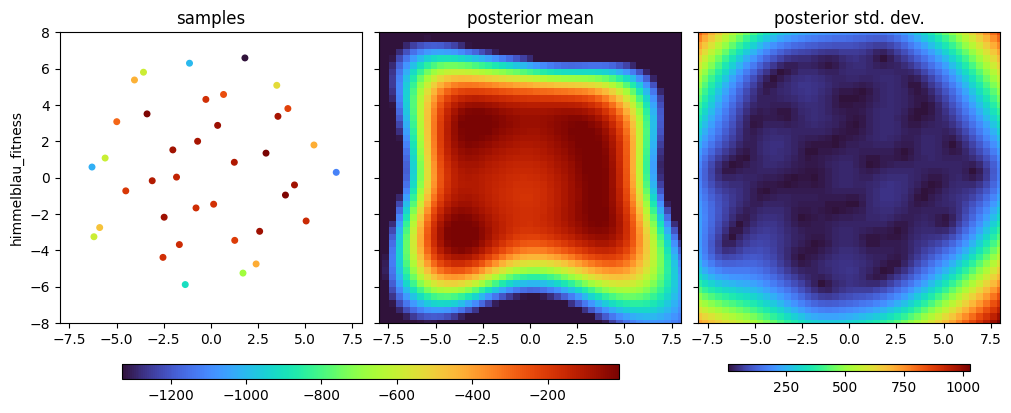

In [3]:
%run -i ../../../examples/prepare_bluesky.py # prepare the bluesky environment

from bloptools import devices
from bloptools.bayesian import Agent

dofs = [
    {"device": devices.DOF(name="x1"), "limits": (-8, 8), "kind": "active"},
    {"device": devices.DOF(name="x2"), "limits": (-8, 8), "kind": "active"},
]

tasks = [
    {"key": "himmelblau", "kind": "minimize"},
]

agent = Agent(
    dofs=dofs,
    tasks=tasks,
    digestion=digestion,
    db=db,
)

RE(agent.initialize("qr", n_init=64))

agent.plot_tasks()

In addition to modeling the fitness of the task, the agent models the probability that an input will be feasible:

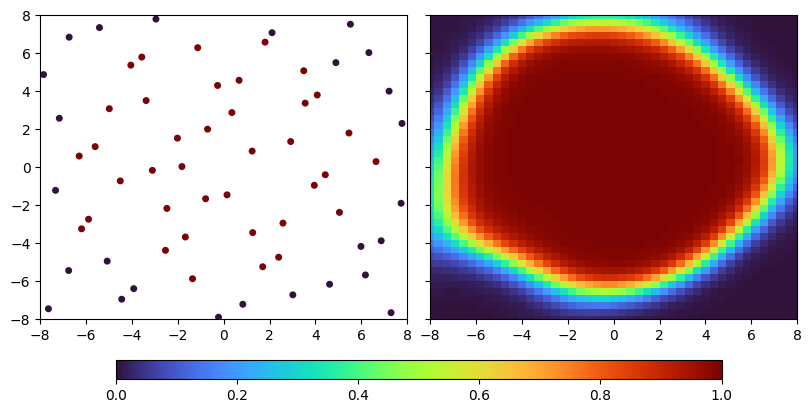

In [4]:
agent.plot_feasibility()

It combines the estimate of the objective and the estimate of the feasibility in deciding where to go:

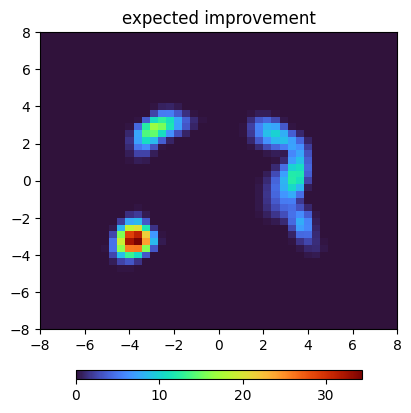

In [5]:
agent.plot_acquisition(acq_func=["ei", "pi", "ucb"])

In [6]:
RE(agent.learn("ei", n_per_iter=4))



Transient Scan ID: 2     Time: 2023-08-11 05:54:18
Persistent Unique Scan ID: '690bbbf0-5ece-4e44-879d-8876903d023c'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 05:54:18.3 |      2.393 |      2.587 |
|         2 | 05:54:18.3 |     -2.336 |      3.083 |
|         3 | 05:54:18.3 |     -2.886 |      2.681 |
|         4 | 05:54:18.3 |     -3.845 |     -2.566 |
+-----------+------------+------------+------------+
generator list_scan ['690bbbf0'] (scan num: 2)





('690bbbf0-5ece-4e44-879d-8876903d023c',)

The agent automatically tries to avoid infeasible points, but will end up naturally exploring the boundary of the constraint. Let's see where the agent is thinking of going:

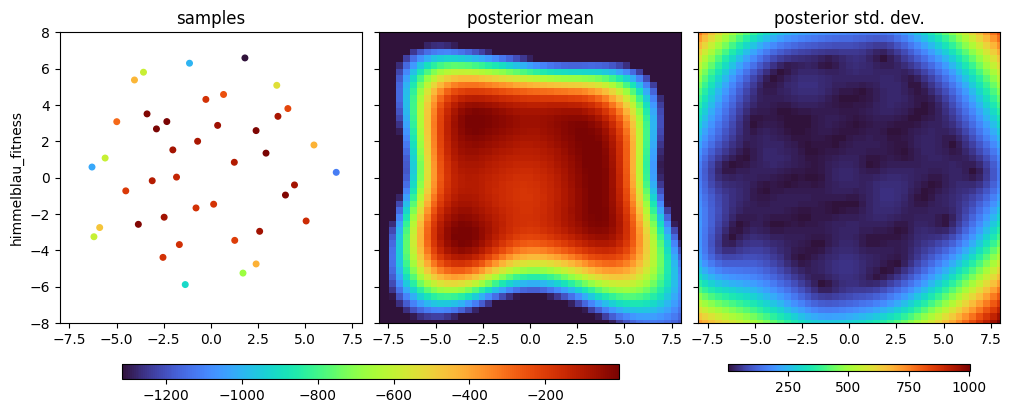

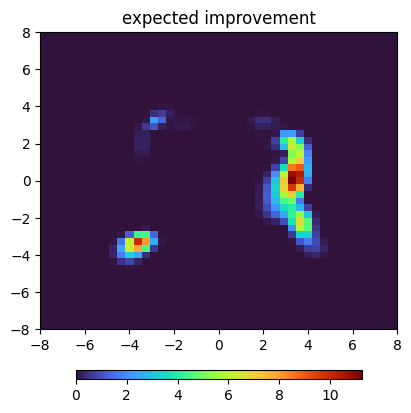

In [7]:
agent.plot_tasks()
agent.plot_acquisition(strategy=["ei", "pi", "ucb"])

The agent will naturally explore the whole parameter space



Transient Scan ID: 3     Time: 2023-08-11 05:54:21
Persistent Unique Scan ID: '47d8f47f-1b07-4371-8868-806377508218'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 05:54:21.5 |      3.376 |      0.150 |
+-----------+------------+------------+------------+
generator list_scan ['47d8f47f'] (scan num: 3)







Transient Scan ID: 4     Time: 2023-08-11 05:54:22
Persistent Unique Scan ID: '61f3e362-c16e-45d9-9460-93ca633ce219'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 05:54:22.4 |     -3.170 |     -3.457 |
+-----------+------------+------------+------------+
generator list_scan ['61f3e362'] (scan num: 4)







Transient Scan ID: 5     Time: 2023-08-11 05:54:23
Persistent Unique Scan ID: 'be2de37f-59a7-49fe-a6df-b46219252303'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 05:54:23.2 |      3.857 |     -1.710 |
+-----------+------------+------------+------------+
generator list_scan ['be2de37f'] (scan num: 5)







Transient Scan ID: 6     Time: 2023-08-11 05:54:24
Persistent Unique Scan ID: '388de2b1-e20c-42ac-a670-53f65fabf3b8'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 05:54:24.1 |      3.280 |      2.016 |
+-----------+------------+------------+------------+
generator list_scan ['388de2b1'] (scan num: 6)







Transient Scan ID: 7     Time: 2023-08-11 05:54:25
Persistent Unique Scan ID: 'ff51fbec-0cca-4caa-bc9f-4b9ad890079d'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 05:54:25.1 |      3.125 |     -2.246 |
+-----------+------------+------------+------------+
generator list_scan ['ff51fbec'] (scan num: 7)







Transient Scan ID: 8     Time: 2023-08-11 05:54:26
Persistent Unique Scan ID: '824ffca6-aced-49ee-b8eb-0442806e8bd8'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 05:54:26.0 |      3.899 |     -2.696 |
+-----------+------------+------------+------------+
generator list_scan ['824ffca6'] (scan num: 8)







Transient Scan ID: 9     Time: 2023-08-11 05:54:26
Persistent Unique Scan ID: '2c63f650-8368-4cc0-80c7-d79fe79f4e46'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 05:54:26.8 |     -2.581 |      3.735 |
+-----------+------------+------------+------------+
generator list_scan ['2c63f650'] (scan num: 9)







Transient Scan ID: 10     Time: 2023-08-11 05:54:27
Persistent Unique Scan ID: 'c44c6c1b-07d4-42b2-8e0c-fce59116c5de'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 05:54:27.8 |     -4.231 |     -3.395 |
+-----------+------------+------------+------------+
generator list_scan ['c44c6c1b'] (scan num: 10)







Transient Scan ID: 11     Time: 2023-08-11 05:54:28
Persistent Unique Scan ID: '8e64a5da-4462-4c8b-a2c3-7109081b394a'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 05:54:28.6 |      3.464 |      1.315 |
+-----------+------------+------------+------------+
generator list_scan ['8e64a5da'] (scan num: 11)







Transient Scan ID: 12     Time: 2023-08-11 05:54:29
Persistent Unique Scan ID: 'ad20ba6f-ba4e-4711-aae5-7ae9af21938c'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 05:54:29.7 |     -2.969 |      3.077 |
+-----------+------------+------------+------------+
generator list_scan ['ad20ba6f'] (scan num: 12)







Transient Scan ID: 13     Time: 2023-08-11 05:54:30
Persistent Unique Scan ID: '9d30d1cb-2573-43b6-ba79-0647d2f78ce4'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 05:54:30.5 |      3.650 |     -2.133 |
+-----------+------------+------------+------------+
generator list_scan ['9d30d1cb'] (scan num: 13)







Transient Scan ID: 14     Time: 2023-08-11 05:54:31
Persistent Unique Scan ID: '42e27d0d-2f52-4316-8064-17937a52b9a5'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 05:54:31.5 |      3.564 |     -2.076 |
+-----------+------------+------------+------------+
generator list_scan ['42e27d0d'] (scan num: 14)







Transient Scan ID: 15     Time: 2023-08-11 05:54:32
Persistent Unique Scan ID: '63764d21-6b9b-401a-b303-d57e0bb3425c'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 05:54:32.2 |      3.418 |     -1.146 |
+-----------+------------+------------+------------+
generator list_scan ['63764d21'] (scan num: 15)







Transient Scan ID: 16     Time: 2023-08-11 05:54:33
Persistent Unique Scan ID: '21eaa49a-7826-4cd0-b5aa-e2433381eddc'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 05:54:33.3 |     -2.979 |      2.947 |
+-----------+------------+------------+------------+
generator list_scan ['21eaa49a'] (scan num: 16)







Transient Scan ID: 17     Time: 2023-08-11 05:54:34
Persistent Unique Scan ID: '8c16ab5c-3b87-4afb-b0c3-c5a3068e45ca'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 05:54:34.2 |      2.809 |      2.189 |
+-----------+------------+------------+------------+
generator list_scan ['8c16ab5c'] (scan num: 17)







Transient Scan ID: 18     Time: 2023-08-11 05:54:35
Persistent Unique Scan ID: '7f23be5a-82d5-4ae4-9bfa-d408b556f211'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 05:54:35.4 |      3.592 |     -1.757 |
+-----------+------------+------------+------------+
generator list_scan ['7f23be5a'] (scan num: 18)





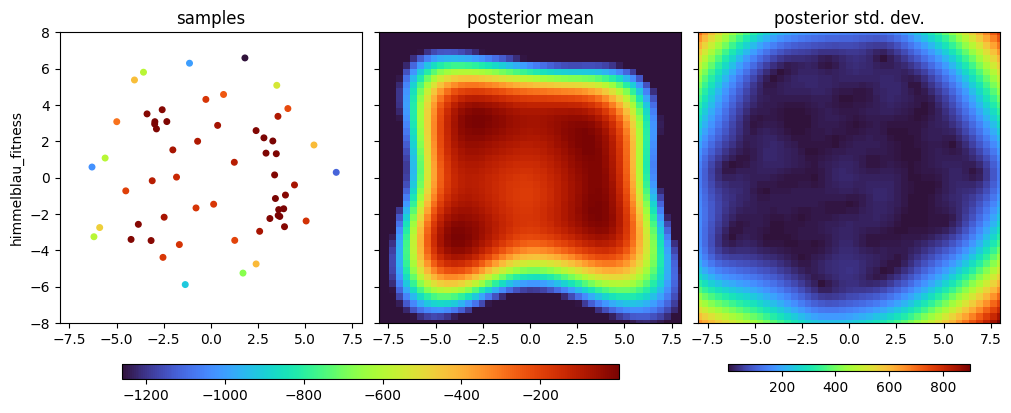

In [8]:
RE(agent.learn("ei", n_iter=16))
agent.plot_tasks()